Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# With Automated Machine Learning
### Energy Demand Forecasting ###

Automated ML empowers data scientists like me to identify an end-to-end machine learning pipeline for any problem, and I am able to achieve higher accuracy while spending far less of my time. 

It enables a much larger number of experiments to be run.

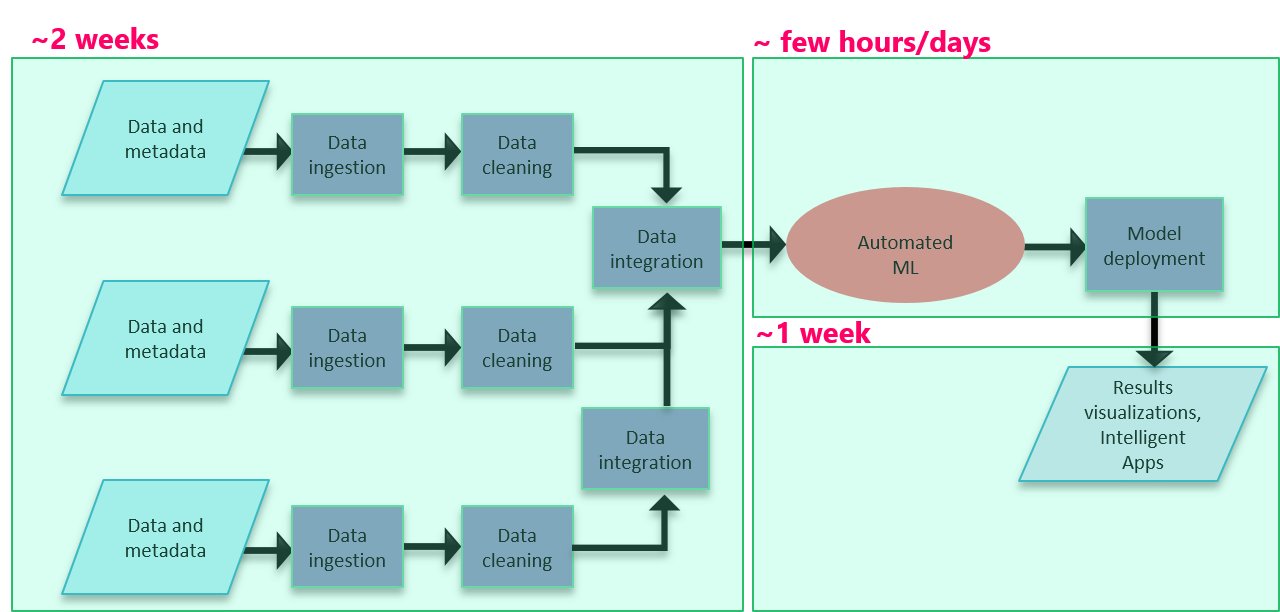

In [1]:
from IPython.display import Image
Image(filename='./WithAutoML.png',width=900)

## Introduction
In this example, we show how AutoML can be used for energy demand forecasting. Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

In this notebook we will walk through the following steps:
1. Creating an experiment in an existing Workspace


2. Ingesting energy data and enriching it with weather data from Azure Open Datasets

    2.1 - Load the enriched data using Azure Open Datasets
    
    2.2 - Split the data into train and test sets


3. Instantiating AutoMLConfig for Automated ML


4. Training your model using local compute


5. Exploring the results and retrieve the best model
    
    5.1 - View the engineered names for featurized data
    
    5.2 - Test the best fitted model
    
    5.3 - Calculate accuracy metrics
    
    5.4 - Model Explainability: what features matter for the forecast?
    
       
6. Registering and deploying your model

    6.1 Define your entry script & dependencies

    6.2 Define your deployment configuration

## 1. Creating an experiment in an existing workspace 


In [1]:
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings
# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None


from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

As part of the setup you have already created a <b>Workspace</b>. For AutoML you would need to create an <b>Experiment</b>. An <b>Experiment</b> is a named object in a <b>Workspace</b>, which is used to run experiments.

In [2]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-energydemandforecasting'
# project folder
project_folder = './sample_projects/automl-local-energydemandforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.33
Subscription ID,5d9f0467-1e93-45cb-9531-b2f8e715feb1
Workspace,aiconfnycws
Resource Group,aiconfnyc
Location,eastus
Project Directory,./sample_projects/automl-local-energydemandforecasting
Run History Name,automl-energydemandforecasting


## 2. Ingesting energy data and enriching it with weather data from Azure Open Datasets Data

In [3]:
data = pd.read_csv("nyc_energy.csv", parse_dates=['timeStamp'])
data.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61


### 2.1 Load the enriched data using Azure Open Datasets 
Read energy demand data from a CSV file, and preview data. To do this, we create an Azure ML Dataset, which is a new entity in your Azure ML workspace: https://publicdataset.azurewebsites.net/ 

Azure Machine Learning Datasets (preview) make it easy to access and work with your data,reuse datasets for various scenarios such as model training and pipeline creation. Using the Azure Machine Learning SDK, you can work with data in popular formats, access underlying storage, explore and prepare data, manage the life cycle of different dataset definitions, and compare between datasets used in training and in production.

In [4]:
enriched = pd.read_csv("nyc_energy_enriched.csv", parse_dates=['timeStamp'])
enriched.head()

,Unnamed: 0,timeStamp,demand,lat,long,datetime,precipTime,precipDepth,snowDepth,temperature
0,0,2012-01-01 00:00:00,4937.50,40.70,-74.01,2012-01-01 00:00:00,2.90,0.77,0.00,7.67
1,1,2012-01-01 01:00:00,4752.10,40.70,-74.01,2012-01-01 01:00:00,2.90,0.77,0.00,7.67
2,2,2012-01-01 02:00:00,4542.60,40.70,-74.01,2012-01-01 02:00:00,2.90,0.77,0.00,7.67
3,3,2012-01-01 03:00:00,4357.70,40.70,-74.01,2012-01-01 03:00:00,2.90,0.77,0.00,7.67
4,4,2012-01-01 04:00:00,4275.50,40.70,-74.01,2012-01-01 04:00:00,2.90,0.77,0.00,7.67


In [5]:
# let's take note of what columns means what in the data
time_column_name = 'timeStamp'
target_column_name = 'demand'

### 2.2 Split the data into train and test sets


In [6]:
X_train = data[data[time_column_name] < '2017-02-01']
X_test = data[data[time_column_name] >= '2017-02-01']
y_train = X_train.pop(target_column_name).values
y_test = X_test.pop(target_column_name).values

## 3. Instantiating AutoMLConfig for Automated ML

Here we are using new task type "forecasting" for timeseries data training, and other timeseries related settings to instantiate a AutoMLConfig object.

What I love the most of Automated ML is that even if it accelerates my work as data scientist, I still have total <b>Control</b>, <b>Transparency</b>, <b>Visibility</b> on what I am doing with my data, the training piece and all the metrics it is using to evaluate different ML approaches.

Below there is the <b>Configuration file</b> for submitting an Automated Machine Learning experiment in Azure Machine Learning service.

This configuration object contains and persists the parameters for configuring the experiment run parameters, as well as the training data to be used at run time.


|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iterations**|Number of iterations. In each iteration, Auto ML trains a specific pipeline on the given data|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], targets values.|
|**n_cross_validations**|Number of cross validation splits.|
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. 

In [7]:
automl_settings = {
    "time_column_name": time_column_name    
}


automl_config = AutoMLConfig(task = 'forecasting',
                             debug_log = 'automl_nyc_energy_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations = 10,
                             iteration_timeout_minutes = 5,
                             X = X_train,
                             y = y_train,
                             n_cross_validations = 3,
                             path=project_folder,
                             verbosity = logging.INFO,
                            **automl_settings)

## 4. Training your model using local compute
Submitting the configuration will start a new run in this experiment. For local runs, the execution is synchronous.
You will see the currently running iterations printing to the console.

In [8]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_60a5158b-2b8d-440e-a27e-e5bea691a145
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:29       0.0504    0.0504
         1   StandardScalerWrapper ElasticNet               0:00:20       0.0349    0.0349
         2   StandardScalerWrapp

In [10]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-energydemandforecasting,AutoML_917c5532-0e01-4c61-8f84-e1f7835e198a,automl,NotStarted,Link to Azure Portal,Link to Documentation


In [9]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

#### Optional: if you want you can create or attach an existing compute resource

In [ ]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

## 5. Exploring the results and retrieve the best model
Below we select the best pipeline from our iterations. 

The get_output file allows you to retrieve the best run and fitted model for any logged metric or a particular iteration.

In [9]:
best_run, fitted_model = local_run.get_output()
fitted_model.steps

[('timeseriestransformer', TimeSeriesTransformer(logger=None)),
 ('stackensembleregressor',
  StackEnsembleRegressor(base_learners=[('3', Pipeline(memory=None,
       steps=[('standardscalerwrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x000002BE1555F0F0>), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='l...  min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='random'))]))],
              meta_learner=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
        max_iter=1000, normalize=False, positive=False, precompute=False,
        random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
              training_cv_folds=5))]

### 5.1 View the engineered names for featurized data
Below we display the engineered feature names generated for the featurized data using the time-series featurization.

In [11]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['precip',
 'temp',
 'precip_WASNULL',
 'temp_WASNULL',
 'year',
 'half',
 'quarter',
 'month',
 'day',
 'hour',
 'am_pm',
 'hour12',
 'wday',
 'qday',
 'week']

### 5.2 Test the Best Fitted Model

For forecasting, we will use the `forecast` function instead of the `predict` function. There are two reasons for this.

We need to pass the recent values of the target variable `y`, whereas the scikit-compatible `predict` function only takes the non-target variables `X`. In our case, the test data immediately follows the training data, and we fill the `y` variable with `NaN`. The `NaN` serves as a question mark for the forecaster to fill with the actuals. Using the forecast function will produce forecasts using the shortest possible forecast horizon. The last time at which a definite (non-NaN) value is seen is the _forecast origin_ - the last time when the value of the target is known. 

Using the `predict` method would result in getting predictions for EVERY horizon the forecaster can predict at. This is useful when training and evaluating the performance of the forecaster at various horizons, but the level of detail is excessive for normal use.

In [12]:
# Replace ALL values in y_pred by NaN. 
# The forecast origin will be at the beginning of the first forecast period
# (which is the same time as the end of the last training period).
y_query = y_test.copy().astype(np.float)
y_query.fill(np.nan)
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_fcst, X_trans = fitted_model.forecast(X_test, y_query)

In [13]:
# limit the evaluation to data where y_test has actuals
def align_outputs(y_predicted, X_trans, X_test, y_test, predicted_column_name = 'predicted'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """
    df_fcst = pd.DataFrame({predicted_column_name : y_predicted})
    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index
    
    # align original X_test to y_test    
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')
    
    # drop rows where prediction or actuals are nan 
    # happens because of missing actuals 
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name, predicted_column_name]].notnull().all(axis=1)]
    return(clean)

df_all = align_outputs(y_fcst, X_trans, X_test, y_test)
df_all.head()

,timeStamp,_automl_dummy_grain_col,predicted,precip,temp,demand
0,2017-02-01 00:00:00,_automl_dummy_grain_col,4720.39,0.00,31.45,5090.62
1,2017-02-01 01:00:00,_automl_dummy_grain_col,4652.97,0.00,32.44,4839.25
2,2017-02-01 02:00:00,_automl_dummy_grain_col,4515.63,0.00,33.19,4702.52
3,2017-02-01 03:00:00,_automl_dummy_grain_col,4484.10,0.00,33.61,4629.94
4,2017-02-01 04:00:00,_automl_dummy_grain_col,4611.99,0.00,32.30,4653.38


Looking at `X_trans` is also useful to see what featurization happened to the data.

### Calculate accuracy metrics


In [15]:
def MAPE(actual, pred):
    """
    Calculate mean absolute percentage error.
    Remove NA and values where actual is close to zero
    """
    not_na = ~(np.isnan(actual) | np.isnan(pred))
    not_zero = ~np.isclose(actual, 0.0)
    actual_safe = actual[not_na & not_zero]
    pred_safe = pred[not_na & not_zero]
    APE = 100*np.abs((actual_safe - pred_safe)/actual_safe)
    return np.mean(APE)

Simple forecasting model
[Test Data] 
Root Mean squared error: 449.61
mean_absolute_error score: 318.66
MAPE: 5.18


<IPython.core.display.Javascript object>


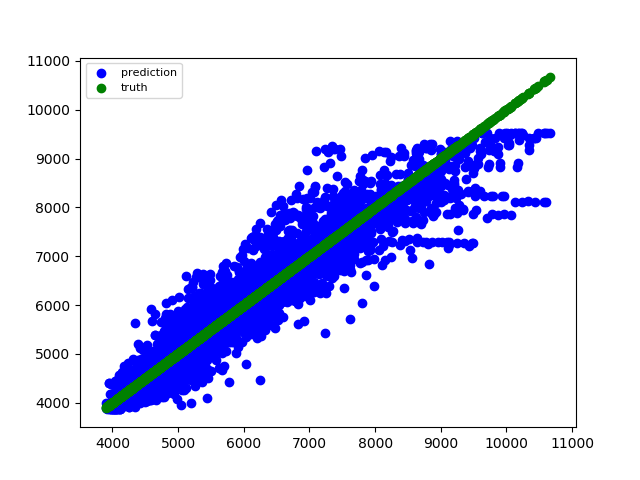

In [16]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
%matplotlib notebook
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

We did not use lags in the previous model specification. Automated ML allows you to use `target_lags` and `target_rolling_window_size`.

Now that we configured target lags, that is the previous values of the target variables, and the prediction is no longer horizon-less. We therefore must specify the `max_horizon` that the model will learn to forecast. The `target_lags` keyword specifies how far back we will construct the lags of the target variable, and the `target_rolling_window_size` specifies the size of the rolling window over which we will generate the `max`, `min` and `sum` features.

In [17]:
automl_settings_lags = {
    'time_column_name': time_column_name,
    'target_lags': 1,
    'target_rolling_window_size': 5,
    # you MUST set the max_horizon when using lags and rolling windows
    # it is optional when looking-back features are not used 
    'max_horizon': len(y_test), # only one grain
}


automl_config_lags = AutoMLConfig(task = 'forecasting',
                             debug_log = 'automl_nyc_energy_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             iterations = 10,
                             iteration_timeout_minutes = 5,
                             X = X_train,
                             y = y_train,
                             n_cross_validations = 3,
                             path=project_folder,
                             verbosity = logging.INFO,
                            **automl_settings_lags)

In [18]:
local_run_lags = experiment.submit(automl_config_lags, show_output=True)

Running on local machine
Parent Run ID: AutoML_c99bba87-434b-4b4d-829f-e11b5a347133
The lag-lead operator was removed due to memory limitation.
The rolling window operator was removed due to memory limitation.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler ElasticNet                        0:00:19       0.1039    0.10

In [19]:
best_run_lags, fitted_model_lags = local_run_lags.get_output()
y_fcst_lags, X_trans_lags = fitted_model_lags.forecast(X_test, y_query)
df_lags = align_outputs(y_fcst_lags, X_trans_lags, X_test, y_test)
df_lags.head()

,timeStamp,_automl_dummy_grain_col,predicted,precip,temp,demand
0,2017-02-01 00:00:00,_automl_dummy_grain_col,4859.57,0.00,31.45,5090.62
1,2017-02-01 01:00:00,_automl_dummy_grain_col,4727.45,0.00,32.44,4839.25
2,2017-02-01 02:00:00,_automl_dummy_grain_col,4598.11,0.00,33.19,4702.52
3,2017-02-01 03:00:00,_automl_dummy_grain_col,4575.99,0.00,33.61,4629.94
4,2017-02-01 04:00:00,_automl_dummy_grain_col,4684.78,0.00,32.30,4653.38


Forecasting model with lags
[Test Data] 
Root Mean squared error: 455.72
mean_absolute_error score: 326.13
MAPE: 5.39


<IPython.core.display.Javascript object>


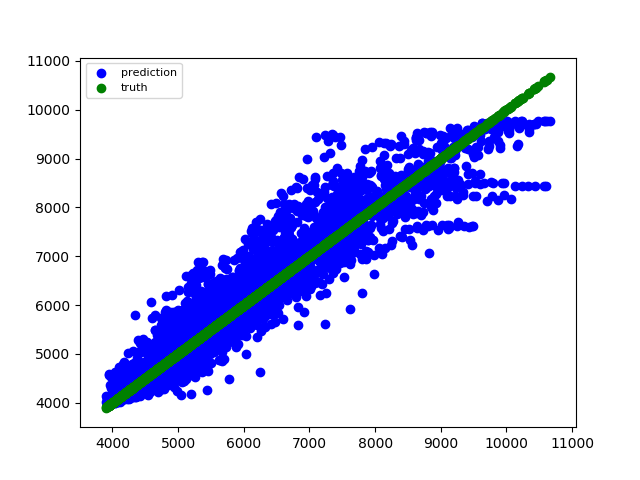

In [21]:
print("Forecasting model with lags")
rmse = np.sqrt(mean_squared_error(df_lags[target_column_name], df_lags['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_lags[target_column_name], df_lags['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_lags[target_column_name], df_lags['predicted']))

# Plot outputs
%matplotlib notebook
test_pred = plt.scatter(df_lags[target_column_name], df_lags['predicted'], color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

### 5.4 Model Explainability: What features matter for the forecast?

I can also use model explainability with Automated ML - This gives me transparency into how the model was built and what features has the most influence on the prediction.  
 
The informative features make all sorts of intuitive sense. Temperature is a strong driver of heating and cooling demand in NYC. Apart from that, the daily life cycle, expressed by `hour`, and the weekly cycle, expressed by `wday` drives people's energy use habits. 

In [22]:
from azureml.train.automl.automlexplainer import explain_model

# feature names are everything in the transformed data except the target
features = X_trans.columns[:-1]
expl = explain_model(fitted_model, X_train, X_test, features = features, best_run=best_run_lags, y_train = y_train)
# unpack the tuple
shap_values, expected_values, feat_overall_imp, feat_names, per_class_summary, per_class_imp = expl
best_run_lags

Experiment,Id,Type,Status,Details Page,Docs Page
automl-energydemandforecasting,AutoML_c99bba87-434b-4b4d-829f-e11b5a347133_9,,Completed,Link to Azure Portal,Link to Documentation


Please go to the Azure Portal's best run to see the top features chart.

The informative features make all sorts of intuitive sense. Temperature is a strong driver of heating and cooling demand in NYC. Apart from that, the daily life cycle, expressed by `hour`, and the weekly cycle, expressed by `wday` drives people's energy use habits.

## 6. Registering and deploying your model
The model registry is a way to store and organize your trained models in the Azure cloud. Models are registered in your Azure Machine Learning service workspace.

In [115]:
description = 'AutoML NYC Energy forecaster'
tags = None
model = local_run_lags.register_model(description = description, tags = tags)

print(local_run_lags.model_id)

Registering model AutoMLc99bba874best
AutoMLc99bba874best


### 6.1 Define your entry script & dependencies
The script contains two functions that load and run the model:

- *init()*: Typically this function loads the model into a global object. This function is run only once when the Docker container for your web service is started.
- *run(input_data)*: This function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization. You can also work with raw binary data. You can transform the data before sending to the model, or before returning to the client.


In [122]:
%%writefile score_fcast.py
import pickle
import json
import numpy as np
import pandas as pd
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelid>>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

timestamp_columns = ['timeStamp']

def run(rawdata, test_model = None):
    """
    Intended to process 'rawdata' string produced by
    
    {'X': X_test.to_json(), y' : y_test.to_json()}
    
    Don't convert the X payload to numpy.array, use it as pandas.DataFrame
    """
    columns = []
    target = ""
    try:
        # unpack the data frame with timestamp     
        rawobj = json.loads(rawdata)                    # rawobj is now a dict of strings
        y_pred = np.array(rawobj['y'])                  # reconstitute numpy array from serialized list
        # We do not have grain columns so we may needd to add them.
        grain_column_names = model.grain_column_names if test_model is None else test_model.grain_column_names
        X_pred = pd.read_json(rawobj['X'], convert_dates=False)   # load the pandas DF from a json string
        if grain_column_names[0] not in X_pred.columns:
            X_pred[grain_column_names[0]]=grain_column_names[0]
        X_pred.sort_index(inplace=True)
        for col in timestamp_columns:                             # fix timestamps
            if X_pred.dtypes[col] == "object":
                # Handle the string conversion to date.
                X_pred[col] = pd.to_datetime(X_pred[col]) 
            else:
                X_pred[col] = pd.to_datetime(X_pred[col], unit='ms') 
        X_copy = X_pred.copy()           
        
        if test_model is None:
            result = model.forecast(X_pred, y_pred)       # use the global model from init function
            target = model._ts_transformer.target_column_name
            index = [model.time_column_name] + model.grain_column_names
        else:
            result = test_model.forecast(X_pred, y_pred)  # use the model on which we are testing
            target = test_model._ts_transformer.target_column_name
            index = [test_model.time_column_name] + test_model.grain_column_names
        
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    
    # Make sure forecast is sorted in the same orger as an input, so the output Y will align.
    dfForecast = result[1]
    dfForecast.reset_index(drop=False, inplace=True)
    dfForecast = dfForecast[index + [target]]
    # Make sure index is the same.
    X_copy['ix'] = X_copy.index
    dfForecast = X_copy.merge(dfForecast, how='left', on=index)
    dfForecast.set_index('ix', drop=True, inplace=True)
    dfForecast.sort_index(inplace=True)
    dfForecast = dfForecast[timestamp_columns + [target]]
    target_vals = dfForecast.pop(target).values
    forecast_as_list = target_vals.tolist()
    return json.dumps({"forecast": forecast_as_list,   # return the minimum over the wire: 
                       "index": dfForecast.to_json()  # no forecast and its featurized values
                      })

Overwriting score_fcast.py


In [100]:
# get the model
from azureml.train.automl.run import AutoMLRun

experiment = Experiment(ws, experiment_name)
ml_run = AutoMLRun(experiment = experiment, run_id = local_run_lags.id)
best_iteration = int(str.split(best_run_lags.id,'_')[-1])      # the iteration number is a postfix of the run ID.

In [123]:
# get the best model's dependencies and write them into this file
from azureml.core.conda_dependencies import CondaDependencies

conda_env_file_name = 'fcast_env.yml'

dependencies = ml_run.get_run_sdk_dependencies(iteration = best_iteration)
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'], pip_packages=['azureml-sdk[automl]'])

myenv.save_to_file('.', conda_env_file_name)

No issues found in the SDK package versions.
azureml-train-automl	1.0.32
azureml-sdk	1.0.32
azureml-core	1.0.32


'fcast_env.yml'

In [124]:
# this is the script file name we wrote a few cells above
script_file_name = 'score_fcast.py'

# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

# Substitute the actual model id in the script file.

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', local_run_lags.model_id))

In [125]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'type': "automl-energy-forecasting"},
                                 description = "Image for ny energy forecasting sample")

image = Image.create(name = "automl-energy-fcast-image",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

if image.creation_state == 'Failed':
    print("Image build log at: " + image.image_build_log_uri)

Creating image
Running..................................................................
SucceededImage creation operation finished for image automl-energy-fcast-image:9, operation "Succeeded"


### 6.2 Define your deployment configuration
Before deploying, you must define the deployment configuration. The deployment configuration is specific to the compute target that will host the web service. For example, when deploying locally you must specify the port where the service accepts requests.

Here we use Azure Container Instances to run serverless Docker containers in Azure with simplicity and speed. 

In [129]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': "automl-energy-forecasting"},
                                               description = "Automl ny energy forecasting service")

In [130]:
from azureml.core.webservice import Webservice

aci_service_name = 'automl-energy-fc-01'
print(aci_service_name)

aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)
aci_service.scoring_uri

automl-energy-fc-01
Creating service
Running........................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


'http://52.224.142.86:80/score'

In [131]:
print(aci_service.get_logs())

2019-05-03T00:54:02,058148601+00:00 - nginx/run 
2019-05-03T00:54:02,069068202+00:00 - iot-server/run 
2019-05-03T00:54:02,071685574+00:00 - gunicorn/run 
2019-05-03T00:54:02,076792515+00:00 - rsyslog/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2019-05-03T00:54:02,430238753+00:00 - iot-server/finish 1 0
2019-05-03T00:54:02,431870898+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 19.6.0
Listening at: http://127.0.0.1:9090 (14)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 46
'pattern' package not found; tag filters are not available for English
Initializing logger
Starting up app insights client
Starting up request id generator
Starting up app insight hooks
Invoking user's init function
2019-05-03 00:54:08,454 | azureml.core.run | DEBUG | Could not load run context Could not load a submitted run, if outside of an execution context, use experiment.start_logging to initialize an azureml.core.Run., 